In [1]:
import pandas as pd
import numpy as np
import os.path 
import pandas_datareader.data as web
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean
import time

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def grab_data(file):
    
    path = './stock-data/Stocks/'+file
    data = pd.read_csv(path)
    data.Date = data.Date.apply(lambda x: np.datetime64(x))
    data.set_index('Date',inplace=True)
    
    return data.copy()

In [3]:
class stock:
    def __init__(self,file):
        self.ticker = file[:-7]
        self.data = grab_data(file)
            
    def grab_returns(self,window=2,featurelength=255):
        self.window=window
        self.featurelength = featurelength
        self.returns = self.data.Close.pct_change(periods=self.window)
        self.maxreturn = self.returns.max()
        self.maxend = np.datetime64(self.returns[self.returns==self.maxreturn].index[0])
        self.maxbegin = self.returns.loc[self.returns.index<=self.maxend].tail(self.window).index[0]
        self.maxreturndata = self.data.loc[(self.data.index<=self.maxend)&(self.data.index>=(self.maxbegin))]
        self.maxoneyear = self.data[(self.data.index<=self.maxend) & (self.data.index>=(self.maxbegin-np.timedelta64(366,'D')))]
        self.featurewindow = self.data[self.data.index<self.maxbegin][-(featurelength+200):]
        self.featurewindow['MA200'] = self.featurewindow.Close.rolling(window=200).mean()
        self.featurewindow['MA100'] = self.featurewindow.Close.rolling(window=100).mean()
        self.featurewindow['MA50'] = self.featurewindow.Close.rolling(window=50).mean()
        self.featurewindow['MA20'] = self.featurewindow.Close.rolling(window=20).mean()
        self.featurewindow['MA10'] = self.featurewindow.Close.rolling(window=10).mean()
        self.featurewindow = self.featurewindow[-(featurelength+1):].drop(['Open','High','Low','OpenInt'],axis=1)
        self.featurewindow['index'] = list(range(len(self.featurewindow)))
        self.featurewindow.set_index('index',append=True,inplace=True)
        self.featurewindowP = self.data[(self.data.index>self.maxend)][:featurelength]
        
        
    def normalize(self,mode='avg'):
        if mode=='pct':
            self.featurewindow.loc[:,'Close'] = self.featurewindow.pct_change().loc[:,'Close']
            self.featurewindow.loc[:,'MA200'] = self.featurewindow.pct_change().loc[:,'MA200']
            self.featurewindow.loc[:,'MA100'] = self.featurewindow.pct_change().loc[:,'MA100']
            self.featurewindow.loc[:,'MA50'] = self.featurewindow.pct_change().loc[:,'MA50']
            self.featurewindow.loc[:,'MA20'] = self.featurewindow.pct_change().loc[:,'MA20']
            self.featurewindow.loc[:,'MA10'] = self.featurewindow.pct_change().loc[:,'MA10']
            self.featurewindow.dropna(inplace=True)
            
        if mode=='avg':
            for col in self.featurewindow.columns:
                if col == 'Volume':
                    continue
                self.featurewindow.loc[:,col] = (self.featurewindow[col]-self.featurewindow[col].mean())/self.featurewindow[col].std()
        
            for col in self.featurewindowP.columns:
                self.featurewindowP.loc[:,col] = (self.featurewindowP[col]-self.featurewindowP[col].mean())/self.featurewindowP[col].std()
            
            for col in self.maxreturndata.columns:
                self.maxreturndata.loc[:,col] = (self.maxreturndata[col]-self.maxreturndata[col].mean())/self.maxreturndata[col].std()
            
    def engineer_features(self,mode='basic',count=2):
        self.features = []
        
        if mode == 'basic':
            for col in self.featurewindow.columns:
                self.features += list(self.featurewindow[col])
                
        if mode == 'discrete':
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            self.featuretemp = self.featurewindow.iloc[points].copy()
            for col in self.featuretemp.columns:
                self.features += list(self.featuretemp[col])
            del self.featuretemp
            
        if mode == 'interval': # only takes the avg closing prices (should normalize first) and volume over the intervals
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Close.mean()]
            for k in range((count-1)):
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Volume.mean()]
                
        if mode == 'interval_g': # take the geometric mean of daily returns over each interval. need to first normalize to %
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                if k == (count - 2):
                        self.features += [gmean(self.featurewindow.iloc[points[k]:(points[k+1]+1)].Close+1)-1]
                        continue
                self.features += [gmean(self.featurewindow.iloc[points[k]:points[k+1]].Close+1)-1]
                
        if mode == 'interval_gv': # take volatility of intervals as well (SD of returns). need to first normalize to % 
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                if k == (count - 2): # ensures that we get the last day of the feature window
                        self.features += [gmean(self.featurewindow.iloc[points[k]:(points[k+1]+1)].Close+1)-1]
                        self.features += [self.featurewindow.iloc[points[k]:(points[k+1]+1)].Close.std()]
                        continue
                self.features += [gmean(self.featurewindow.iloc[points[k]:points[k+1]].Close+1)-1]
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Close.std()]

In [4]:
k1 = 2
k2 = 3
k3 = 5

stock_df1 = pd.DataFrame(columns=list(range(k1-1)))
stock_df2 = pd.DataFrame(columns=list(range(k2-1)))
stock_df3 = pd.DataFrame(columns=list(range(k3-1)))

for file in os.listdir('./stock-data/Stocks'):
    try:
        stk = stock(file)
        stk.grab_returns(window=25)
        stk.normalize(mode='pct')
        
        stk.engineer_features(mode='interval_gv',count=k1)
        temp1 = [stk.ticker.upper()]+[stk.featurewindow.index.get_level_values(0)[0]]+stk.features
        stock_df1 = stock_df1.append(pd.DataFrame(temp1).transpose())
        
        stk.engineer_features(mode='interval_gv',count=k2)
        temp2 = [stk.ticker.upper()]+stk.features
        stock_df2 = stock_df2.append(pd.DataFrame(temp2).transpose())
        
        stk.engineer_features(mode='interval_gv',count=k3)
        temp3 = [stk.ticker.upper()]+stk.features
        stock_df3 = stock_df3.append(pd.DataFrame(temp3).transpose())
        del stk
    except:
        continue
        
stock_df1.columns=(['ticker','begin_date']+list(range(len(stock_df1.columns)-2)))
stock_df1 = stock_df1.set_index(['ticker','begin_date'])
symbols_dates = stock_df1.drop([0,1],axis=1).copy()
stock_df1.reset_index(inplace=True)
stock_df1.drop('begin_date',axis=1,inplace=True)
stock_df1 = stock_df1.set_index('ticker')

stock_df2.columns=(['ticker']+list(range(len(stock_df2.columns)-1)))
stock_df2 = stock_df2.set_index('ticker')

stock_df3.columns=(['ticker']+list(range(len(stock_df3.columns)-1)))
stock_df3 = stock_df3.set_index('ticker')

C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:315: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# this could be avoided if we used a single dataframe and used dropna(), but we will keep them separate for clarity

#symbols_dates = symbols_dates[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]
#stock_df1 = stock_df1[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]
#stock_df2 = stock_df2[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]
#stock_df3 = stock_df3[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]

#symbols_dates = symbols_dates[list(stock_df3[1].notnull().values)]
#stock_df1 = stock_df1[list(stock_df3[1].notnull().values)]
#stock_df2 = stock_df2[list(stock_df3[1].notnull().values)]
#stock_df3 = stock_df3[list(stock_df3[1].notnull().values)]

In [23]:
#symbols_dates.to_csv('./results/second-sample/symbols-dates.csv')
#stock_df1.to_csv('./results/second-sample/df1.csv',index=False)
#stock_df2.to_csv('./results/second-sample/df2.csv',index=False)
#stock_df3.to_csv('./results/second-sample/df3.csv',index=False)

symbols_dates = pd.read_csv('./results/second-sample/symbols-dates.csv')
stock_df1 = pd.read_csv('./results/second-sample/df1.csv')
stock_df2 = pd.read_csv('./results/second-sample/df2.csv')
stock_df3 = pd.read_csv('./results/second-sample/df3.csv')

In [28]:
# the values of geometric means and SDs are on slightly different scales -- we normalize across the data set before clustering
# (subtracting the mean is technically unnecessary..)

for col in stock_df1.columns:
    stock_df1[col] = (stock_df1[col]-stock_df1[col].mean())/stock_df1[col].std()
    
for col in stock_df2.columns:
    stock_df2[col] = (stock_df2[col]-stock_df2[col].mean())/stock_df2[col].std()
    
for col in stock_df3.columns:
    stock_df3[col] = (stock_df3[col]-stock_df3[col].mean())/stock_df3[col].std()

In [29]:
from sklearn.cluster import KMeans

KM1 = KMeans(n_clusters=3,random_state=2).fit(stock_df1.values)
KM2 = KMeans(n_clusters=9,random_state=2).fit(stock_df2.values)
KM3 = KMeans(n_clusters=81,random_state=2).fit(stock_df3.values)

In [31]:
intermediate_labels = pd.DataFrame()

intermediate_labels['one'] = KM1.labels_
intermediate_labels['two'] = KM2.labels_
intermediate_labels['four'] = KM3.labels_

merge_list = [pd.get_dummies(intermediate_labels.one),
              pd.get_dummies(intermediate_labels.two),
              pd.get_dummies(intermediate_labels.four)]

dummies = pd.concat(merge_list,axis=1)
dummies.columns = list(range(93))

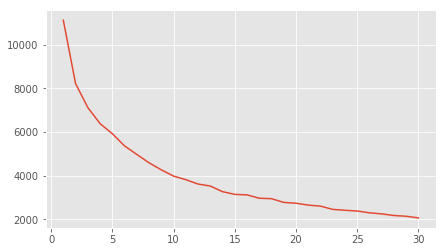

In [32]:
SS = []

for k in range(1,31):
    KM_FINAL = KMeans(n_clusters=k,random_state=2).fit(dummies.values)
    SS.append(KM_FINAL.inertia_)

fig, ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(range(1,31),SS)

In [33]:
KM_FINAL = KMeans(n_clusters=13,random_state=2).fit(dummies.values)
symbols_dates['CLUSTERS'] = KM_FINAL.labels_

In [34]:
symbols_dates.CLUSTERS.value_counts().sort_values(ascending=False)

0     716
1     696
2     539
3     494
5     472
7     393
6     335
8     284
9     271
4     246
12    191
11    175
10    135
Name: CLUSTERS, dtype: int64

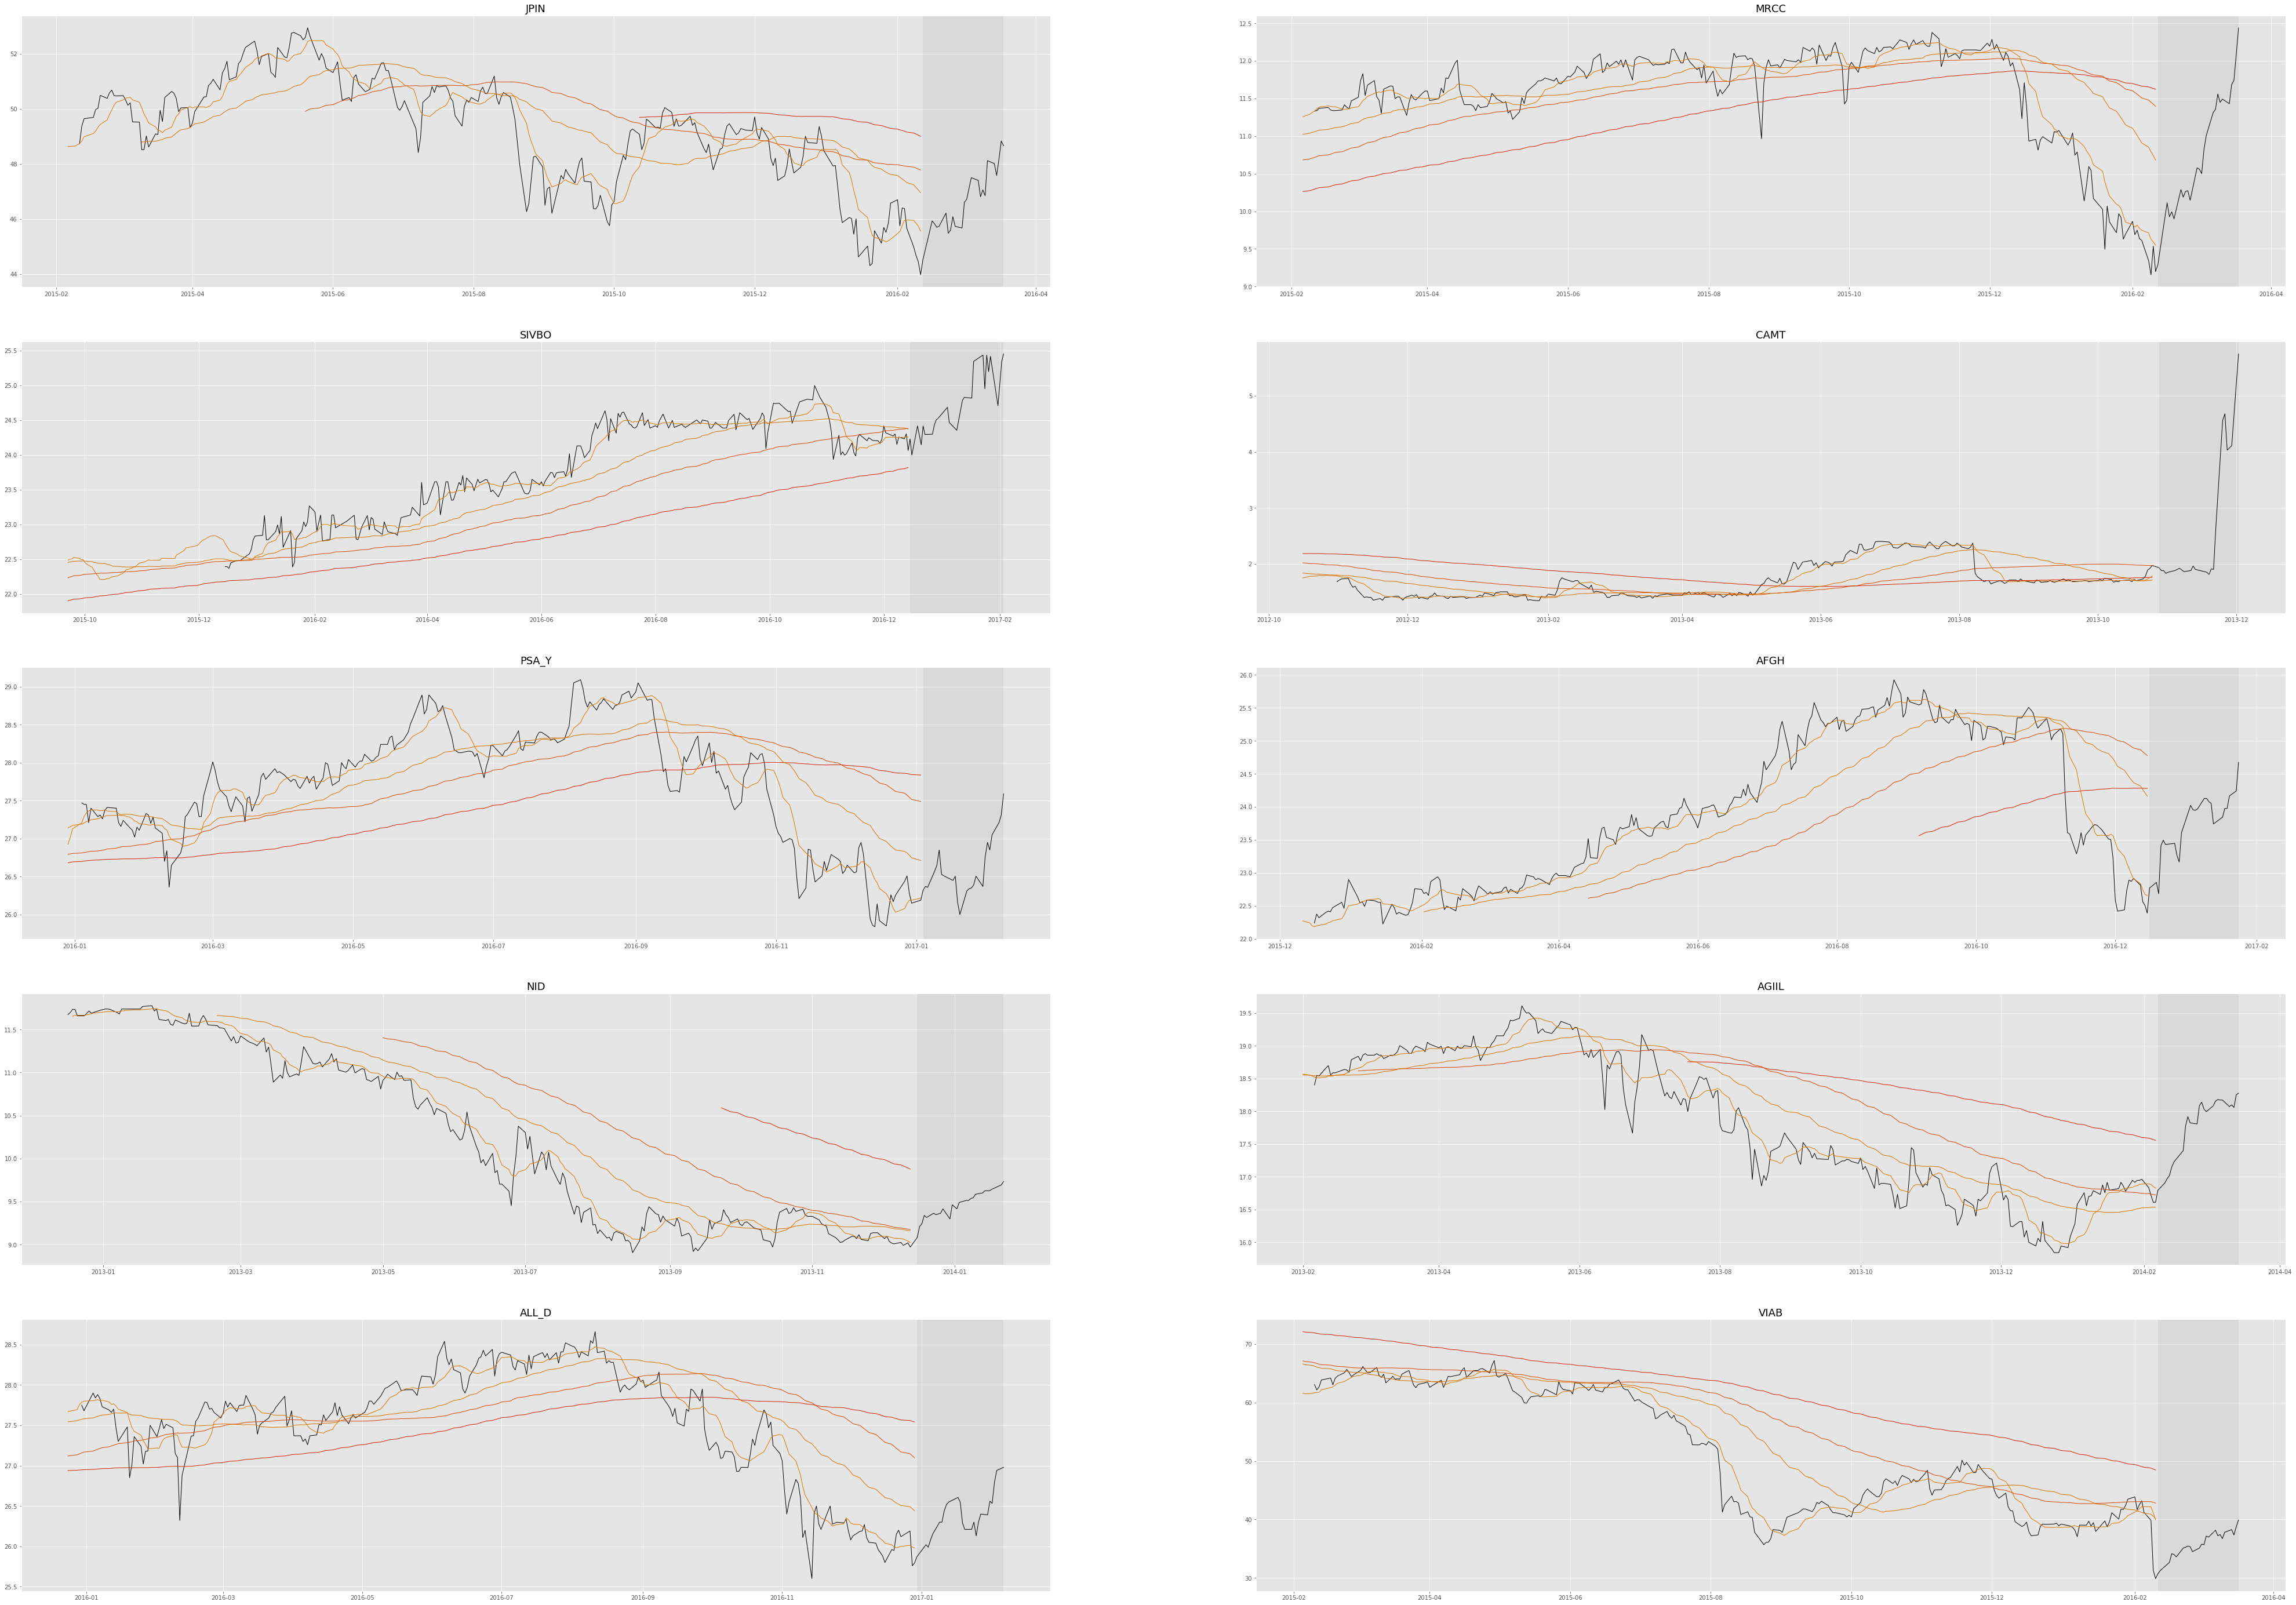

In [48]:
# still have the issue of sub-clusters within clusters..

fig = plt.figure(figsize=(70,50))

for i,tck in enumerate(symbols_dates[symbols_dates.CLUSTERS==0].ticker.sample(10,random_state=2)):
    file = tck.lower()+'.us.txt'
    b = stock(file)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(5,2,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck,fontsize=18)

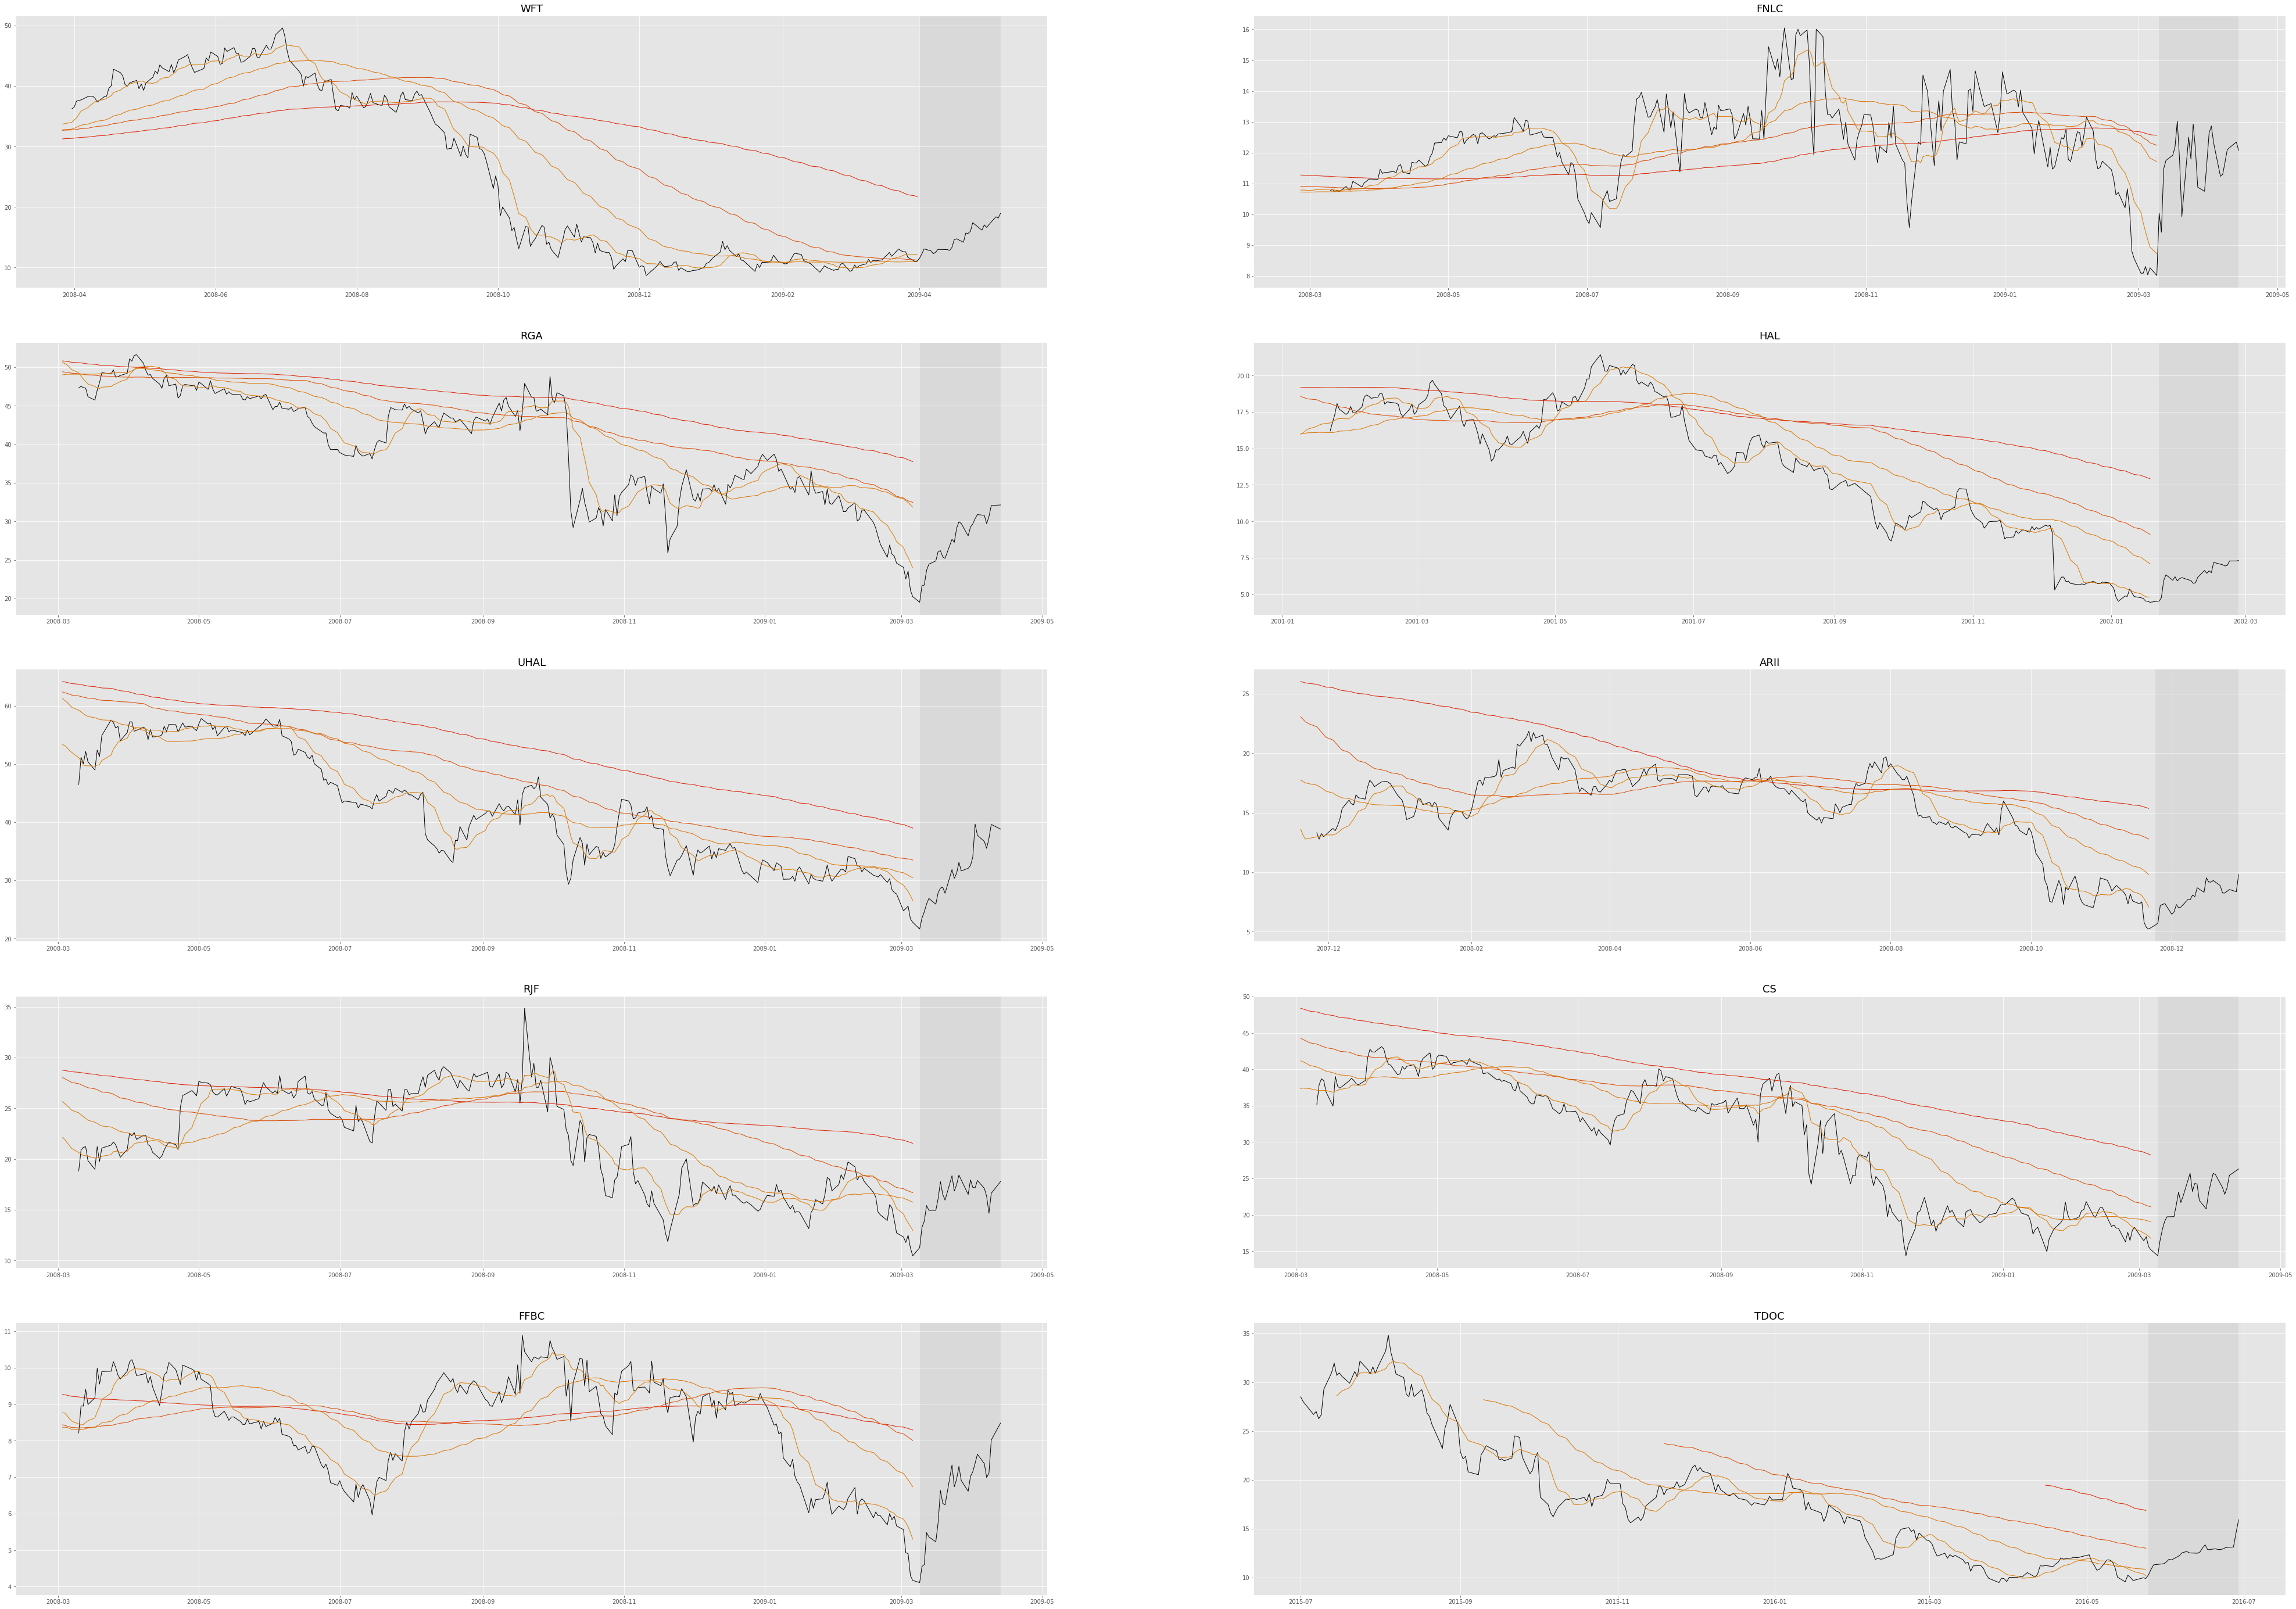

In [50]:


fig = plt.figure(figsize=(70,50))

for i,tck in enumerate(symbols_dates[symbols_dates.CLUSTERS==1].ticker.sample(10,random_state=10)):
    file = tck.lower()+'.us.txt'
    b = stock(file)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(5,2,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck,fontsize=18)

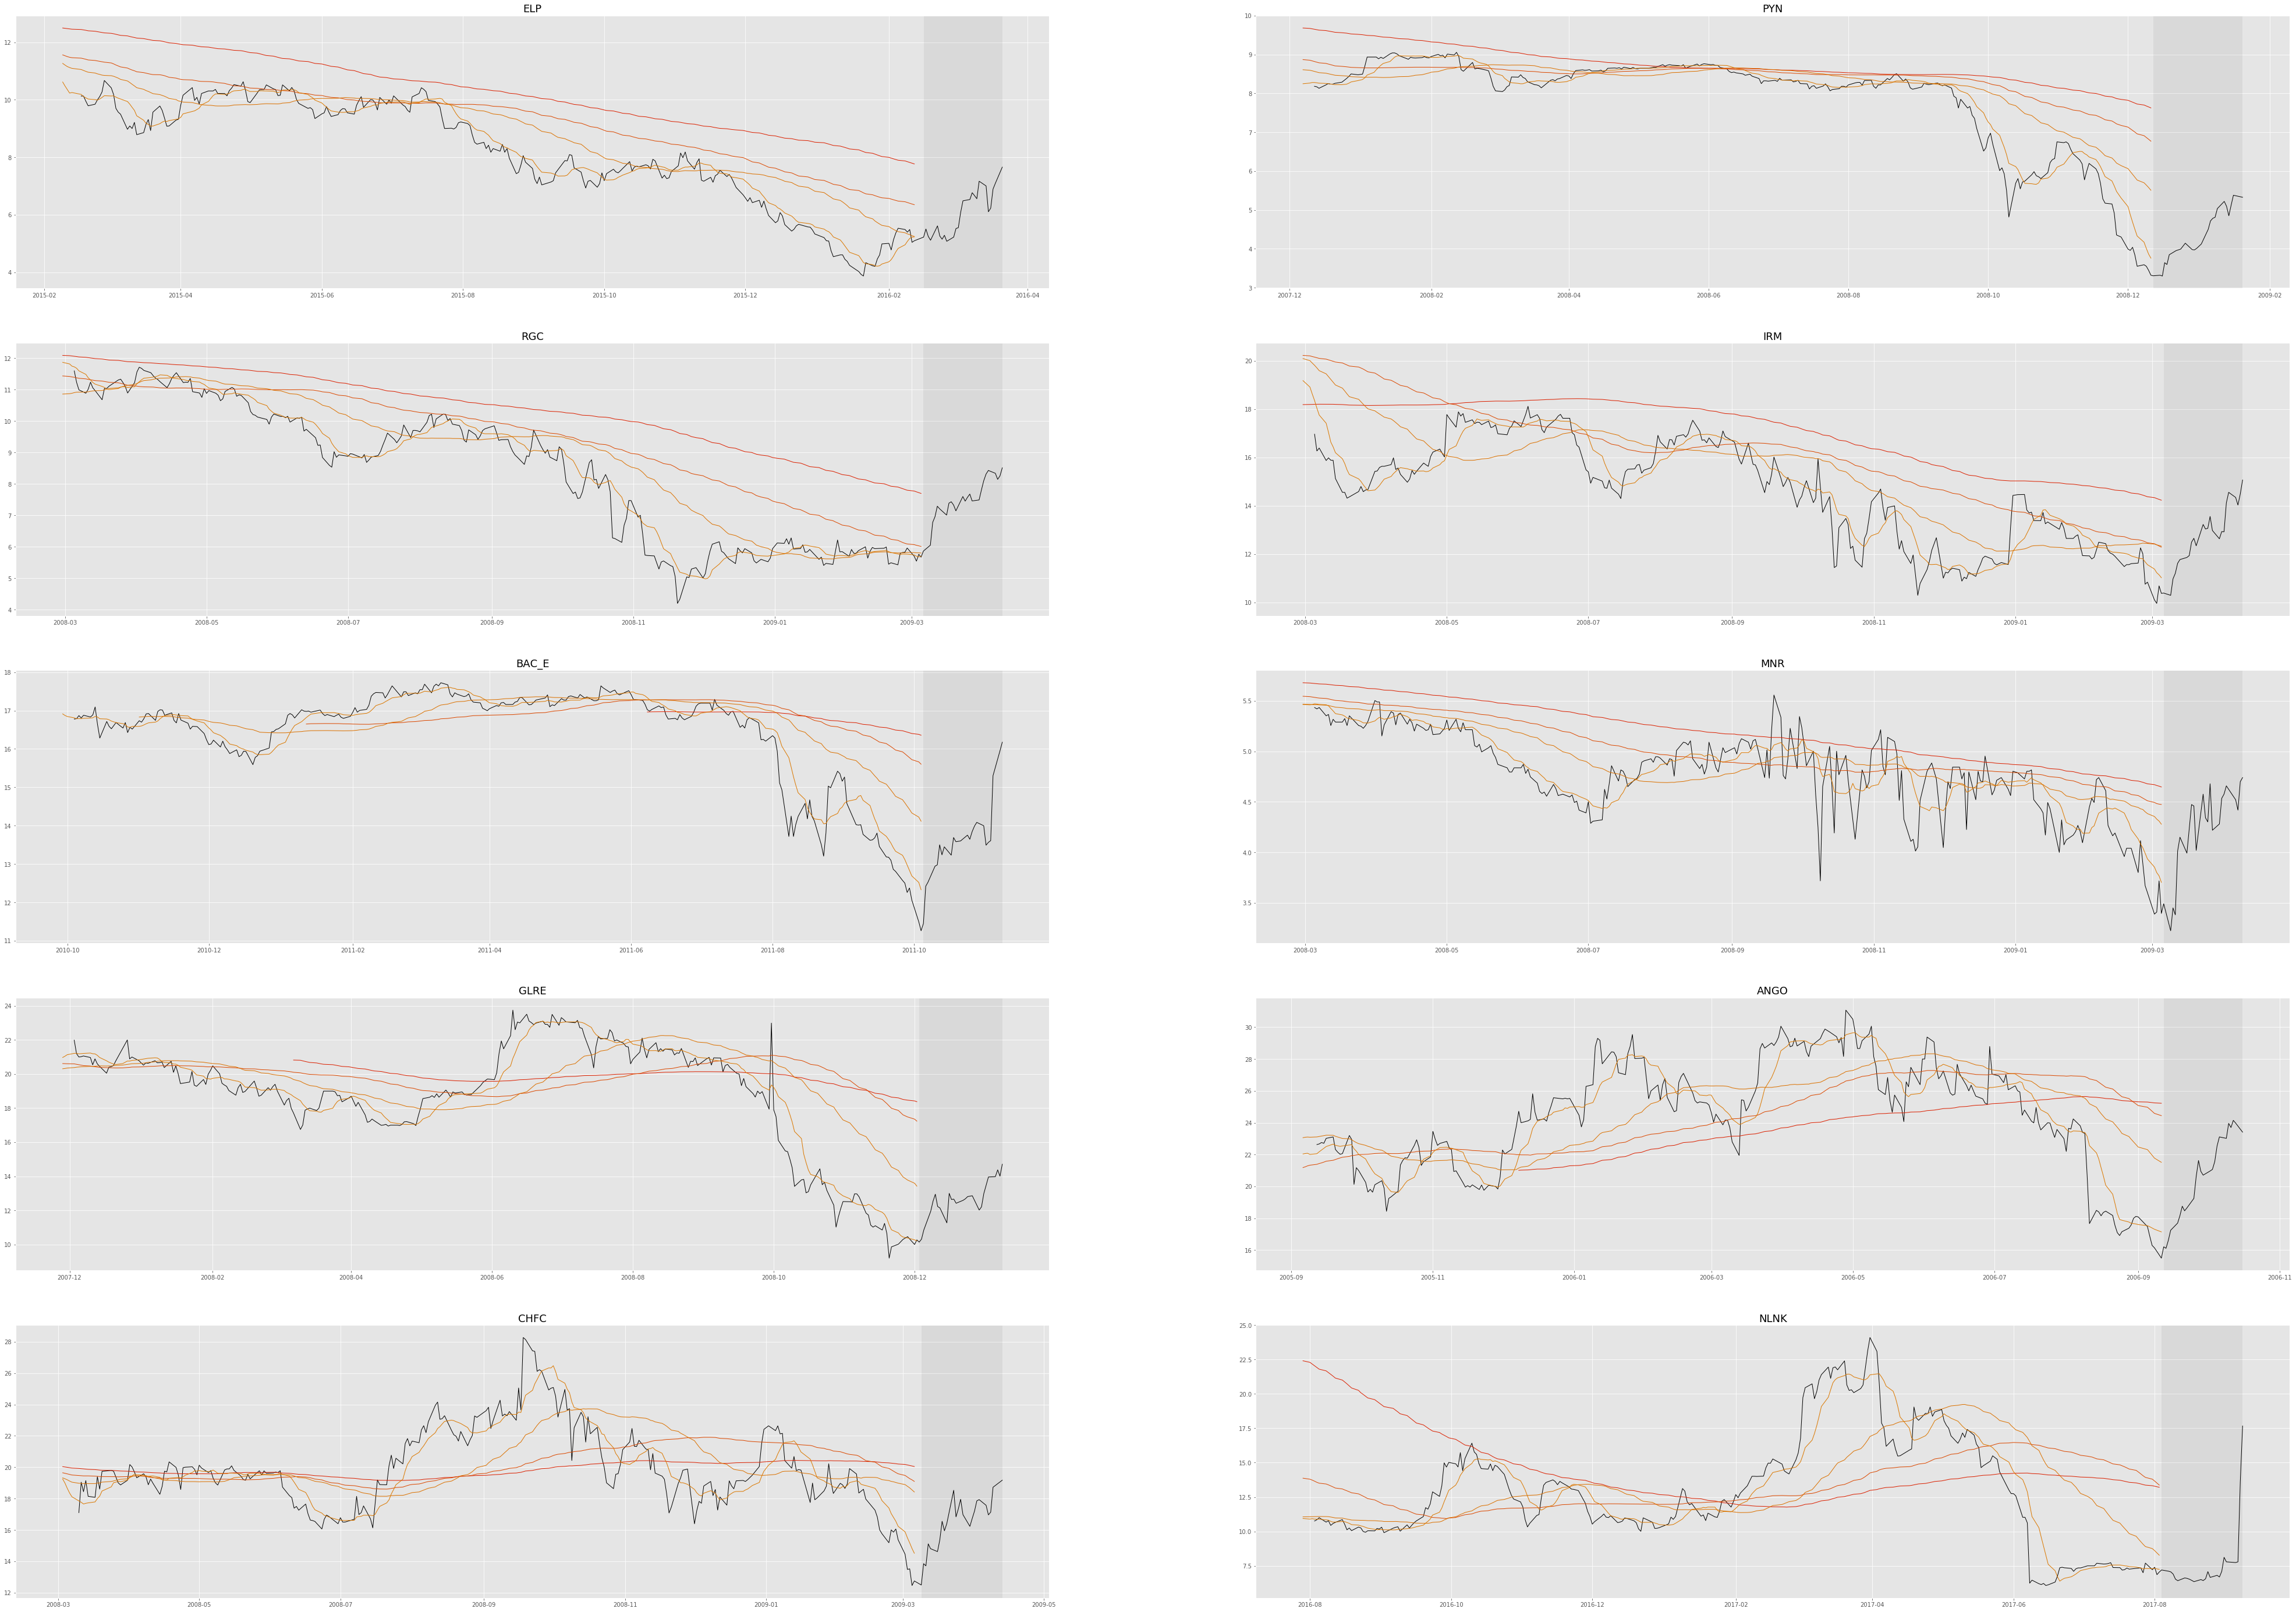

In [52]:
fig = plt.figure(figsize=(70,50))

for i,tck in enumerate(symbols_dates[symbols_dates.CLUSTERS==2].ticker.sample(10,random_state=10)):
    file = tck.lower()+'.us.txt'
    b = stock(file)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(5,2,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck,fontsize=18)